In [1]:
import gymnasium as gym
import numpy as np

## Expert Data

Use pre-trained DQN as expert policy https://github.com/Wangyuxuan-xuan/DQN-Flappybird/blob/main/runs/cartpole2.pt
Use expert policy to generate expert data

Set a limit with max_steps_per_trajectory to control the length of trajectory

In [2]:
import torch
import torch.nn as nn

class ExpertDQN(nn.Module):
    def __init__(self, state_dim=4, action_dim=2, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Load pre-trained expert
expert = ExpertDQN(hidden_dim=10)
expert.load_state_dict(torch.load("Expert_data\cartpole2.pt"))
expert.eval()  # Set to evaluation mode

ExpertDQN(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [3]:
def generate_expert_data(num_trajectories, max_steps_per_trajectory=200):
    env = gym.make("CartPole-v1")
    expert_states = []
    expert_actions = []
    
    for _ in range(num_trajectories):
        state, _ = env.reset()
        done = False
        step = 0
        while not done and step < max_steps_per_trajectory:
            with torch.no_grad():
                q_values = expert(torch.FloatTensor(state))
                action = torch.argmax(q_values).item()
            
            expert_states.append(state)
            expert_actions.append(action)
            state, _, done, _, _ = env.step(action)

            step += 1

    env.close()
    return np.array(expert_states), np.array(expert_actions)

# Generate expert data using your trained DQN
expert_states, expert_actions = generate_expert_data(num_trajectories=200, max_steps_per_trajectory=100)

In [4]:
expert_states, expert_actions

(array([[-0.01943445,  0.03626017,  0.00092384,  0.00421819],
        [-0.01870925,  0.23136887,  0.00100821, -0.2881731 ],
        [-0.01408187,  0.03623255, -0.00475525,  0.00482763],
        ...,
        [ 0.07319589, -0.18640901,  0.00114871,  0.30078515],
        [ 0.06946771,  0.00869655,  0.00716441,  0.00846472],
        [ 0.06964163,  0.20371503,  0.00733371, -0.28194916]],
       dtype=float32),
 array([1, 0, 1, ..., 1, 1, 0]))

In [5]:
def test_expert():
    env = gym.make("CartPole-v1", render_mode="human")
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        q_values = expert(torch.FloatTensor(state))
        action = torch.argmax(q_values).item()
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
    
    print(f"Expert reward: {total_reward}")
    env.close()

# test_expert()

## Define Policy and Discriminator Networks
The discriminator networks Concatenate state and action, This allows the network to learn a joint representation of the state and action

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.net(state)

class Discriminator(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    # Concatenate state and action, This allows the network to learn a joint representation of the state and action
    def forward(self, state, action):
        sa = torch.cat([state, action], dim=-1)
        return self.net(sa)

# Initialize networks
state_dim = 4  # CartPole state dimension
action_dim = 2 # CartPole action space (0 or 1)
policy = Policy(state_dim, action_dim)
discriminator = Discriminator(state_dim, 1)  # Action is 0/1, so we encode as 0 or 1

# # Test networks
# state = torch.randn(1, state_dim)
# action = torch.randint(0, 2, (1, 1))
# print("Policy output:", policy(state).shape)
# print("Discriminator output:", discriminator(state, action).shape)

## Train GAIL

#### Loss in GAN
The discriminator's loss in GANs is usually something like maximizing log(D(real)) + log(1 - D(fake)), where D(real) is the probability that real data is real, and D(fake) is the probability that fake data is real

Entropy Term
$$
H(\pi(\cdot \mid s)) = - \sum_{a \in \mathcal{A}} \pi(a \mid s) \log (\pi(a \mid s))
$$


In [ ]:
all_episode_rewards = []
window_len = 100
def train_gail(expert_states, expert_actions, num_epochs=100, batch_size=32, λ=0.1):
    # Initialize optimizers
    policy_optim = optim.Adam(policy.parameters(), lr=1e-3)
    disc_optim = optim.Adam(discriminator.parameters(), lr=1e-3)
    
    for epoch in range(num_epochs):
        # --- Step 1: Sample trajectories from current policy ---
        env = gym.make("CartPole-v1")
        policy_states, policy_actions = [], []
        state, _ = env.reset()
        episode_reward = 0
        done = False


        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)  # Get action probabilities from policy
            action = torch.distributions.Categorical(action_probs).sample().item()  # Sample action
            policy_states.append(state)
            policy_actions.append(action)
            state, reward, done, _, _ = env.step(action)  # Execute action in environment
            episode_reward += reward
        
        all_episode_rewards.append(episode_reward)
        
        # --- Step 2: Update Discriminator ---
        # Prepare expert and policy data as state-action pairs
        expert_sa = torch.cat([
            torch.FloatTensor(expert_states),
            torch.FloatTensor(expert_actions).unsqueeze(1)  # Shape: (N, state_dim + 1)
        ], dim=1)
        policy_sa = torch.cat([
            torch.FloatTensor(policy_states),
            torch.FloatTensor(policy_actions).unsqueeze(1)  # Shape: (M, state_dim + 1)
        ], dim=1)
        
        # Discriminator loss components:
        # - Maximize log(D(expert_sa)): Expert labeled as "real"
        # - Maximize log(1 - D(policy_sa)): Policy labeled as "fake"
        real_output = discriminator(expert_sa[:, :4], expert_sa[:, 4:])  # D(expert_sa)
        fake_output = discriminator(policy_sa[:, :4], policy_sa[:, 4:])   # D(policy_sa)
        real_loss = -torch.log(real_output).mean()  # -E[log(D(expert))]
        fake_loss = -torch.log(1 - fake_output).mean()  # -E[log(1 - D(policy))]
        disc_loss = real_loss + fake_loss  # Total loss
        
        # Update discriminator
        disc_optim.zero_grad()
        disc_loss.backward()
        disc_optim.step()
        
        # --- Step 3: Update Policy using Discriminator as Reward ---
        # Convert policy data to tensors
        policy_states_tensor = torch.FloatTensor(policy_states)
        policy_actions_tensor = torch.FloatTensor(policy_actions).unsqueeze(1)
        
        # Compute rewards: log(D(s,a)) 
        # the discriminator is not exactly a reward function, 
        # but rather a way to estimate the likelihood of a state-action pair being from the expert's policy.
        # If the discriminator thinks it is more likely from expert then it will give a higher reward
        # Thus we can use this as a reward signal to reinforce the actions that can fool the discriminator better
        with torch.no_grad():
            rewards = torch.log(discriminator(policy_states_tensor, policy_actions_tensor))
        
        # Compute policy loss:
        # L = -E[log(π(a|s)) * reward] - λ * entropy(π)
        action_probs = policy(policy_states_tensor)
        entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=-1).mean()  # Avoid log(0)
        log_probs = torch.log(action_probs.gather(1, policy_actions_tensor.long()))  # log(π(a|s))
        # TODO mind the sign of entropy here
        # Here we flip the sign cuz we wanna minimizing
        # We wanna maximizing/reinforce the action with high reward, that equals to minimizing the negative reward
        # The entropy is positive, thus minimizing the negative entropy is maximizing the entropy

        # Policy gradient reinforced by direct rewards Q(s,a), using descriminator as reward signal
        policy_loss = -(log_probs * rewards).mean() - λ * entropy
        
        # Update policy
        policy_optim.zero_grad() 
        policy_loss.backward()
        policy_optim.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Disc Loss = {disc_loss.item():.3f}, Policy Loss = {policy_loss.item():.3f}")

            print(f"Mean rewards for last {window_len} episodes : {mean_last_episodes(all_episode_rewards, window_len)}" )

def mean_last_episodes(rewards, n=20):
    if len(rewards) < n:
        return 0
    return np.mean(rewards[-n:])

In [8]:
train_gail(expert_states, expert_actions, num_epochs=2000, batch_size=32, λ=0.1)

C:\Users\wangy\AppData\Local\Temp\ipykernel_61588\3274586349.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  torch.FloatTensor(policy_states),


Epoch 0: Disc Loss = 1.352, Policy Loss = -0.631
Mean rewards for last 100 episodes : 0
Epoch 100: Disc Loss = 1.302, Policy Loss = -0.558
Mean rewards for last 100 episodes : 18.73
Epoch 200: Disc Loss = 1.245, Policy Loss = -0.586
Mean rewards for last 100 episodes : 26.11
Epoch 300: Disc Loss = 1.211, Policy Loss = -0.568
Mean rewards for last 100 episodes : 34.27
Epoch 400: Disc Loss = 1.133, Policy Loss = -0.590
Mean rewards for last 100 episodes : 44.43
Epoch 500: Disc Loss = 1.136, Policy Loss = -0.638
Mean rewards for last 100 episodes : 54.89
Epoch 600: Disc Loss = 0.985, Policy Loss = -0.747
Mean rewards for last 100 episodes : 68.11
Epoch 700: Disc Loss = 1.091, Policy Loss = -0.551
Mean rewards for last 100 episodes : 63.76
Epoch 800: Disc Loss = 1.096, Policy Loss = -0.668
Mean rewards for last 100 episodes : 76.51
Epoch 900: Disc Loss = 0.923, Policy Loss = -0.801
Mean rewards for last 100 episodes : 65.26
Epoch 1000: Disc Loss = 0.991, Policy Loss = -0.608
Mean rewards f

In [9]:
def test_policy(policy, num_episodes=10):
    env = gym.make("CartPole-v1", render_mode="human")
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            with torch.no_grad():
                action_probs = policy(torch.FloatTensor(state))
            action = torch.argmax(action_probs).item()  # Take most probable action
            state, _, done, _, _ = env.step(action)
    env.close()

# test_policy(policy)

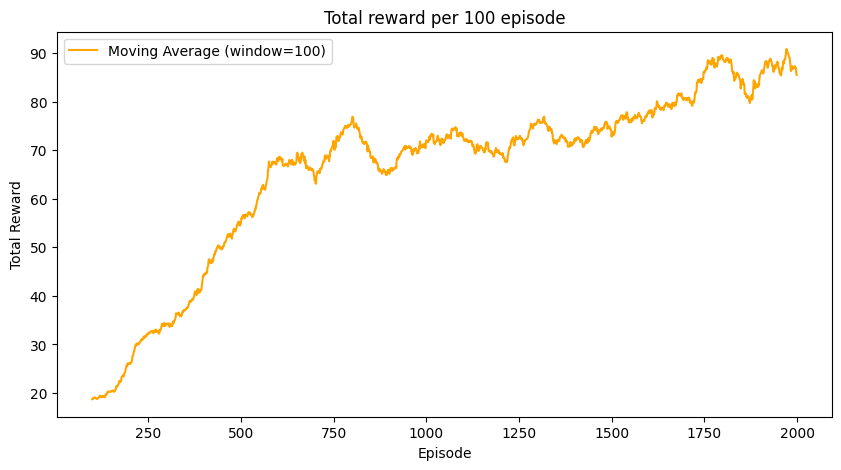

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(episode_rewards, window=1):
    plt.figure(figsize=(10, 5))
    
    if window > 1:
        # Compute moving average
        smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        x = np.arange(window-1, len(episode_rewards))  # Align x-axis with smoothed data
        plt.plot(x, smoothed, label=f"Moving Average (window={window})", color='orange')
        # Optionally plot original with low opacity
        # plt.plot(episode_rewards, label="Original", alpha=0.1, color='blue')
    else:
        plt.plot(episode_rewards, label="Agent")
    
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Total reward per {window} episode")
    plt.legend()
    plt.show()

# Example: Plot with a 100-episode moving average
plot_learning_curve(all_episode_rewards, window=100)